**Imports:**

In [1]:
%reload_ext autoreload
%autoreload 1
from model_files.model import MushroomClassifier,MushroomDataModule
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import cv2
import joblib
import numpy as np
import torch
from torchvision import datasets, transforms
from torchvision.models import resnet18,ResNet18_Weights
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import pytorch_lightning as ptl
from torchmetrics.classification import Accuracy
from torch.utils.data import Subset
from PIL import Image
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import model_files.tuning as tunes
from ray import tune
from ray.tune.stopper import MaximumIterationStopper
from ray.tune.search.optuna import OptunaSearch
from ray import train
from sklearn.metrics import classification_report
%aimport model_files.tuning
%aimport model_files.model

**Settings:**

In [2]:
BASE_FIG_SIZE=(8.5,5)
current_directory = os.getcwd()

## Exploratory Data Analysis

In [3]:
eda_data_module=MushroomDataModule()
eda_data_module.setup()
eda_loader=eda_data_module.train_dataloader()

**Number of samples for each genus:**

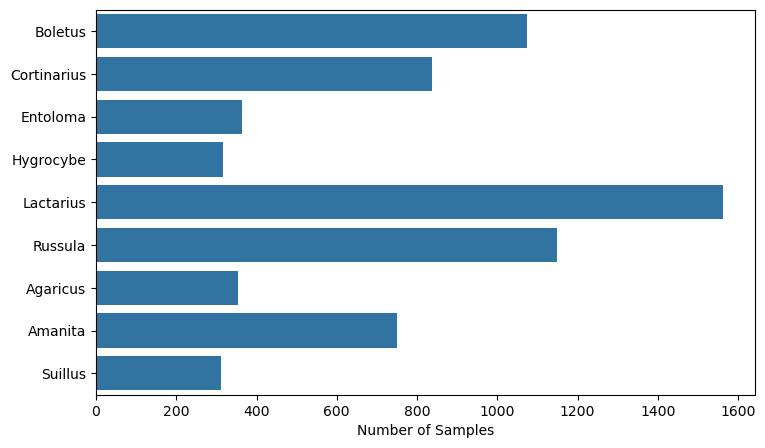

In [4]:
files=os.listdir("Mushrooms")
genuses = [file for file in files]
genus_data_count={}
for genus in genuses:
    pics=os.listdir(f"Mushrooms/{genus}")
    genus_data_count[genus]=len([pic for pic in pics])
genus_data_count
fig_data_count,ax_data_count=plt.subplots(figsize=BASE_FIG_SIZE)
sns.barplot(genus_data_count,orient='y',ax=ax_data_count)
ax_data_count.set_xlabel("Number of Samples")
plt.show()

In [5]:
images=pl.DataFrame(eda_loader.dataset.dataset.samples,schema=['path','class'])
class_dict={item:key for key, item in eda_loader.dataset.dataset.class_to_idx.items()}

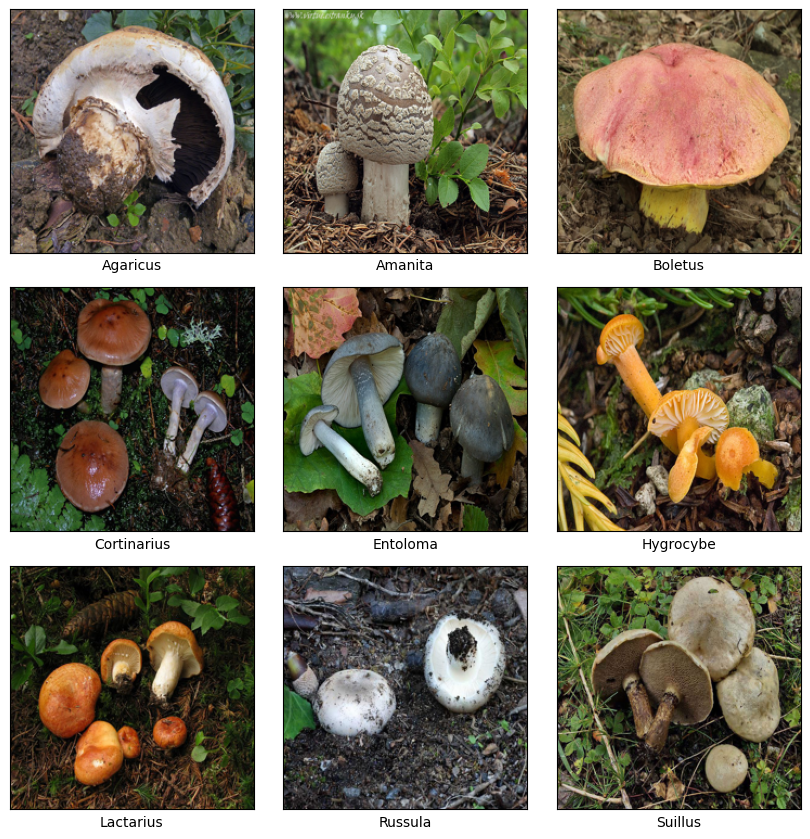

In [6]:
fig_sample,ax_sample=plt.subplots(3,3,figsize=(BASE_FIG_SIZE[0],BASE_FIG_SIZE[0]))
ax_sample=ax_sample.flatten()
for i in range(9):
    path=images.filter(pl.col("class")==i).sample(1)["path"].item()
    image = Image.open(path)
    image = image.resize((225, 225))
    ax_sample[i].imshow(image)
    ax_sample[i].set_xlabel(class_dict[i])
    ax_sample[i].set_xticks([])
    ax_sample[i].set_yticks([])
plt.tight_layout(w_pad=0.1)

**Getting image dimensions:**

**Image dimension distribution by genus:**

sizes

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [8]:
tb_logger = ptl.loggers.TensorBoardLogger('logs')

In [9]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    min_delta=0.001,
)

In [10]:
stopper = MaximumIterationStopper(1)
tuner = tune.Tuner(
    trainable=tune.with_resources(
        tune.with_parameters(
            tunes.TrainableCV,
            model=MushroomClassifier,
            dm=MushroomDataModule,
            metric="val_loss",
            logger=tb_logger,
            callbacks=[early_stopping_callback],
        ),
        resources={"CPU": 2, "GPU": 1},
    ),
    run_config=train.RunConfig(
        stop=stopper,
        storage_path=f"{current_directory}/logs/ray/",
        name="tunning",
        checkpoint_config=train.CheckpointConfig(
            checkpoint_at_end=False,
        ),
    ),
    tune_config=tune.TuneConfig(
        search_alg=OptunaSearch(),
        mode="min",
        metric="score",
        num_samples=50,
    ),
    param_space={
        "batch_size": tune.randint(32, 128),
        "img_size":tune.randint(150,300),
        "max_epochs": 31,
        "learning_rate": tune.loguniform(0.00001, 0.01),
        "num_classes": 9,
        "architecture": tune.choice(["resnet18","squeezenet","google"]),
        "optimizer": tune.choice(["adam","sgd"]),
        "l2":tune.loguniform(1e-6,1)
    },
)

In [11]:
best_params=joblib.load("temp/best_params.joblib")

In [12]:
%load_ext tensorboard
%tensorboard --logdir logs

In [13]:
best_params

{'batch_size': 78,
 'img_size': 292,
 'max_epochs': 31,
 'learning_rate': 0.00019766984899815166,
 'num_classes': 9,
 'architecture': 'resnet18',
 'optimizer': 'adam',
 'l2': 2.538433533212881e-06}

In [14]:
best_model,best_dm=tunes.config_models(best_params,MushroomClassifier,MushroomDataModule)

In [15]:
trainer = ptl.Trainer(
    max_epochs=35,
    accelerator="gpu",
    callbacks=[early_stopping_callback],
    logger=tb_logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(best_model,best_dm)

2023-12-11 15:03:51.010140: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 15:03:51.011649: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 15:03:51.031369: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 15:03:51.031393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 15:03:51.031985: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/gediminas/anaconda3/envs/DL/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [17]:
trainer.test(best_model,best_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8830975294113159
        test_loss           0.38728243112564087
 test_weighted_f1_score     0.8853135108947754
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.38728243112564087,
  'test_accuracy': 0.8830975294113159,
  'test_weighted_f1_score': 0.8853135108947754}]

In [18]:
best_dm.setup()
test_loader=best_dm.test_dataloader()

In [19]:
predictions=trainer.predict(best_model,test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [25]:
predictions_all = torch.cat(predictions, dim=0)
predictions_rounded = torch.argmax(predictions_all, dim=1)
predictions_rounded = pl.DataFrame(predictions_rounded.numpy(), schema=["prediction"])
predictions_rounded = predictions_rounded.with_columns(
    pl.DataFrame(
        [test_loader.dataset.dataset.samples[i] for i in test_loader.dataset.indices]
    )[:, 1].alias("true")
)


In [24]:
print(classification_report(predictions_rounded['true'],predictions_rounded['prediction']))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        71
           1       0.86      0.89      0.88       150
           2       0.92      0.98      0.95       215
           3       0.87      0.82      0.85       167
           4       0.92      0.82      0.87        73
           5       0.90      0.86      0.88        63
           6       0.87      0.91      0.89       313
           7       0.87      0.87      0.87       229
           8       0.91      0.69      0.79        62

    accuracy                           0.88      1343
   macro avg       0.89      0.86      0.87      1343
weighted avg       0.88      0.88      0.88      1343

